In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import KFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import root_mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [2]:
X_train = pd.read_csv('/Users/yeong-injang/Desktop/kaggle/Used_cars/used_cars_x_train.csv')
y_train = pd.read_csv('/Users/yeong-injang/Desktop/kaggle/Used_cars/used_cars_y_train.csv')
X_test = pd.read_csv('/Users/yeong-injang/Desktop/kaggle/Used_cars/used_cars_x_test.csv')
y_test = pd.read_csv('/Users/yeong-injang/Desktop/kaggle/Used_cars/used_cars_y_test.csv')

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2775 entries, 0 to 2774
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   brand                2775 non-null   object 
 1   model_year           2775 non-null   int64  
 2   milage               2775 non-null   int64  
 3   fuel_type            2775 non-null   object 
 4   ext_col_norm         2775 non-null   object 
 5   int_col_norm         2775 non-null   object 
 6   accident             2775 non-null   object 
 7   clean_title          2775 non-null   object 
 8   engine_hp            2237 non-null   float64
 9   engine_displacement  2623 non-null   float64
 10  engine_c             2474 non-null   float64
dtypes: float64(3), int64(2), object(6)
memory usage: 238.6+ KB


In [4]:
num = list(X_train.select_dtypes(include=np.number).columns)
cat = list(X_train.select_dtypes(include='object').columns)
print('numeric columns :', num)
print('categorical columns :', cat)

numeric columns : ['model_year', 'milage', 'engine_hp', 'engine_displacement', 'engine_c']
categorical columns : ['brand', 'fuel_type', 'ext_col_norm', 'int_col_norm', 'accident', 'clean_title']


### Null Imputation

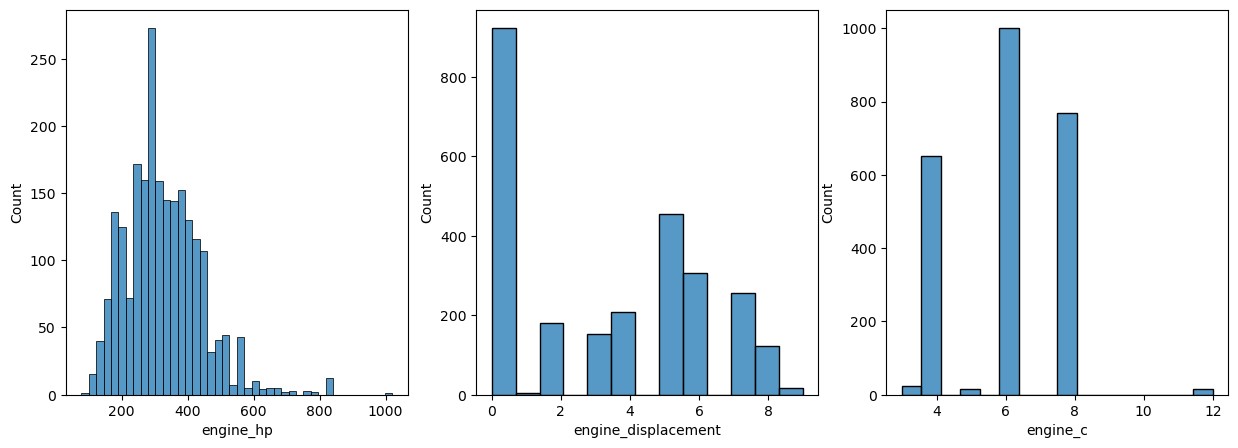

325 3.0 6.0


In [5]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.histplot(X_train['engine_hp'], ax = ax[0])
sns.histplot(X_train['engine_displacement'], ax = ax[1])
sns.histplot(X_train['engine_c'], ax = ax[2])
plt.show()
print(round(X_train['engine_hp'].mean()), round(X_train['engine_displacement'].mean(),0), round(X_train['engine_c'].mean(),0))

In [6]:
imp = SimpleImputer(strategy='mean')
imp.fit(X_train[['engine_hp','engine_displacement','engine_c']])
X_train[['engine_hp','engine_displacement','engine_c']] = imp.transform(X_train[['engine_hp','engine_displacement','engine_c']])
X_test[['engine_hp','engine_displacement','engine_c']] = imp.transform(X_test[['engine_hp','engine_displacement','engine_c']])

In [52]:
preprocessor = ColumnTransformer([('imputer', SimpleImputer(strategy='mean'), ['engine_hp','engine_displacement','engine_c']),
                        ('scaler', MinMaxScaler(), make_column_selector(dtype_include=np.number)),
                        ('one-hot', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object))])
scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
kf = KFold(n_splits=10, shuffle=True, random_state=1)

In [92]:
def ppline(model, preprocessor, X, y):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)])
    pipeline.fit(X, y)
    return(pipeline)

{'max_depth': 13, 'min_samples_leaf': 6}


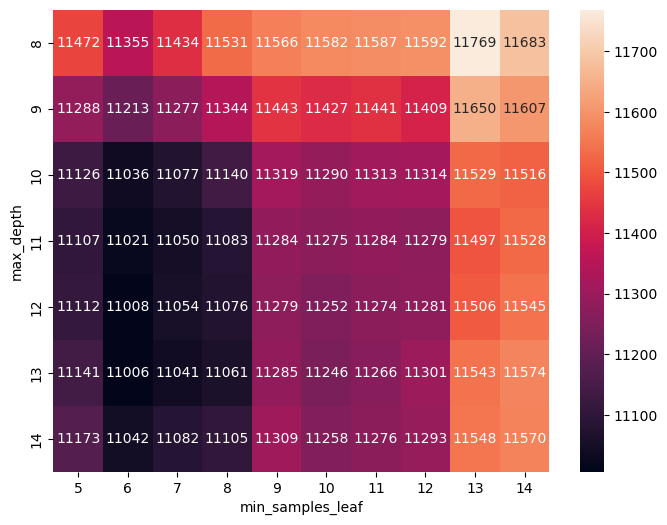

In [85]:
## Decision Tree Parameter Tuning

dt_param_grid = {'max_depth': np.arange(8,15),
                'min_samples_leaf' : np.arange(5,15)}

dt = DecisionTreeRegressor()
dt_grid_search = GridSearchCV(estimator=ppline(dt, preprocessor, X_train, y_train)['model'], param_grid=dt_param_grid, 
                           cv=10, n_jobs=-1, scoring=scorer)
dt_grid_search.fit(preprocessor.transform(X_train).toarray(), y_train)

cv_scores = pd.DataFrame(dt_grid_search.cv_results_['params'])
cv_scores['cv_score'] = dt_grid_search.cv_results_['mean_test_score']*-1

print(dt_grid_search.best_params_)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cv_scores.pivot(index='max_depth', columns='min_samples_leaf', values='cv_score'), annot=True, fmt='.0f')
plt.show()

In [102]:
## Random Forest Parameter Tuning

rf_param_grid = {'n_estimators':[100,500],
                 'max_features' : ['sqrt', 'log2', .2, .4, .6, .8],
                 'min_samples_leaf' : np.arange(10,80,20)}

rf = RandomForestRegressor(random_state=111)

rf_grid_search = GridSearchCV(estimator=ppline(rf, preprocessor, X_train, y_train['price'])['model'], param_grid=rf_param_grid, 
                           cv=10, n_jobs=-1, scoring=scorer)
rf_grid_search.fit(preprocessor.transform(X_train).toarray(), y_train['price'])

rf_grid_search.best_params_

{'max_features': 0.8, 'min_samples_leaf': 10, 'n_estimators': 500}

In [ ]:
models = {'Linear Regression' : LinearRegression(),
         'Ridge' : RidgeCV(alphas=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1], scoring=scorer, cv=kf),
         'Lasso' : LassoCV(cv=kf),
          'Decision Tree Regression' : DecisionTreeRegressor().set_params(**dt_grid_search.best_params_),
          'Random Frest Regression' : RandomForestRegressor(random_state=111).set_params(**rf_grid_search.best_params_)
}



for name, model in models.items():
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)])

    if name == 'Ridge':
        pipeline.fit(X_train, y_train)
        cv_score = model.best_score_ * -1
    elif name == 'Lasso':
        pipeline.fit(X_train, y_train['price'])
        cv_score = root_mean_squared_error(model.predict(preprocessor.transform(X_train)), y_train)
    else:
        cv_score = cross_val_score(pipeline, X_train, y_train['price'], scoring=scorer, cv=kf).mean() * -1
    
    print(name, ':', round(cv_score,2))

Linear Regression : 11473.84
Ridge : 11504.33
Lasso : 14662.78
Decision Tree Regression : 11534.56


In [12]:
# prepare X_test to predict y_test
preprocessor.fit(X_train)
X_test = pd.DataFrame(preprocessor.transform(X_test).toarray(), columns=preprocessor.get_feature_names_out())
X_test.head()

,scaler__model_year,scaler__milage,scaler__engine_hp,scaler__engine_displacement,scaler__engine_c,one-hot__brand_Acura,one-hot__brand_Alfa,one-hot__brand_Aston,one-hot__brand_Audi,one-hot__brand_BMW,...,one-hot__int_col_norm_Orange,one-hot__int_col_norm_Others,one-hot__int_col_norm_Red,one-hot__int_col_norm_Silver,one-hot__int_col_norm_White,one-hot__accident_At least 1 accident or damage reported,one-hot__accident_None reported,one-hot__accident_Unknown,one-hot__clean_title_Unknown,one-hot__clean_title_Yes
0,0.78125,0.511193,0.262697,0.000000,0.111111,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.93750,0.144696,0.262697,0.444444,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.96875,0.057963,0.246285,0.666667,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.65625,0.588745,0.345011,0.222222,0.555556,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.87500,0.115070,0.262697,0.000000,0.111111,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
